# PA005 - High Value Customer Indetification

## 0.0. Planejamento da Solução

### Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização.
    
2. Conjunto de Dados
    - Vendas em um e-commerce online, durante o periodo de um ano.

### Output - Saida

1. Indicação das pessoas que farão parte do programa de Insiders
    - Lista: 
            client_id | is_insider |
              1023     |     Yes  |
              
2. Relatório com as perguntas de negócio:
    - Quem são as pessoas elegiveis para participar do programa de Insiders?
    - Quantos clientes farão parte do grupo?
    - Quais as principais caracteristicas dos clientes?
    - Qual a porcentagem de contribuição do faturamento vinda dos Insiders?
    - Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegivel aos Insiders?
    - Quais as condições para uma pessoa ser removida dos Insiders? 
    - Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks

1. Quem são as pessoas elegiveis para participar do programa de Insiders?
    - O que é ser elegivel? 
    
    - O que são clientes de maior valor?
        - Faturamento: Alto ticket medio, Alto LTV, Baixa Recencia, Alto Basket Size, Baixa probabilidade de Churn, Alta previsão de LTV, Alta probabilidade de compra.
        - Custo: Tem baixa taxa de devolução. 
        - Experiencia de compra: Média alta das avaliações.
        
   
2. Quantos clientes farão parte do grupo?
    - Numero total de clientes
    - % do grupo insiders
    

3. Quais as principais caracteristicas dos clientes?
    - Escrever caracteristicas dos clientes: Idade, Localização. 
    - Caracteristicas do consumo: Atributos da clusterização
    

4. Qual a porcentagem de contribuição do faturamento vinda dos Insiders?
    - Calcula o faturamento total do ano e compara com o faturamento total do grupo.
    

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort
    
    
6. Quais as condições para uma pessoa ser elegivel aos Insiders?
    - Definir a periodicidade: 3 meses, 6 meses..
    - A pessoa precisa ser similar ou parecida com uma pessoa do grupo.
    

7. Quais as condições para uma pessoa ser removida dos Insiders? 
    - Definir a periodicidade: 3 meses, 6 meses..
    - A pessoa precisa ser disimilar ou parecida com uma pessoa do grupo. 
    

8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - Teste A/B Baysiano
    - Teste de Hipóteses.
    

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Frete
    - Preferencia de compra
    - Visita a empresa


# 0.0 Imports

In [154]:
import re

import pandas     as pd
import numpy      as np
import seaborn    as sns
import umap.umap_ as umap

from IPython.core.display import HTML
from sklearn.manifold     import TSNE
from pandas_profiling     import ProfileReport
from sklearn.neighbors    import NearestNeighbors
from yellowbrick.cluster  import KElbowVisualizer, SilhouetteVisualizer

from sklearn              import decomposition as dd
from matplotlib           import pyplot        as plt
from sklearn              import cluster       as c
from sklearn              import metrics       as m
from plotly               import express       as px
from sklearn              import preprocessing as pp
from sklearn              import ensemble      as en
from sklearn              import mixture       as mx
from scipy.cluster        import hierarchy     as hc

## Functions

In [155]:
def jupyter_settings():
    
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
   

    display( HTML( '<style>.container { width:90% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

    
 
def get_statistics( data ):
    
    data = data.select_dtypes( include=['int64', 'float64'] )

    # Central Tendency - mean, median
    ct1 = pd.DataFrame( data.apply( np.mean ) ).T
    ct2 = pd.DataFrame( data.apply( np.median ) ).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( data.apply( np.std ) ).T
    d2 = pd.DataFrame( data.apply( min ) ).T
    d3 = pd.DataFrame( data.apply( max ) ).T
    d4 = pd.DataFrame( data.apply( lambda x: x.max() - x.min() ) ).T
    d5 = pd.DataFrame( data.apply( lambda x: x.skew() ) ).T
    d6 = pd.DataFrame( data.apply( lambda x: x.kurtosis() ) ).T

    # Concat
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [156]:
jupyter_settings()

## Loading Data

In [157]:
df_raw = pd.read_csv('C:/Users/Pedro/repos/pa005_insiders_clustering/insiders_cluster/data/raw/data.csv', encoding='unicode_escape')

# 1.0 Data Description

In [158]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [159]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2 Data Dimensions

In [160]:
print('The number of rows is: {}'.format( df1.shape[0] ))
print('The number of columns is: {}'.format( df1.shape[1] ))

The number of rows is: 541909
The number of columns is: 8


## 1.3 Data Types

In [161]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [162]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [163]:
# Spliting NA's into two differents dataframes

df_missing = df1.loc[ df1['customer_id'].isna(), : ]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [164]:
# Creating Reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1 )

# Merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# Dropping extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [165]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Types

In [166]:
# Invoice Date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'] )

# Customer ID
df1['customer_id'] = df1['customer_id'].astype(np.int64)

## 1.7 Descriptive Statistics

### 1.7.1. Numerical Attributes

In [167]:
get_statistics(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### Numerical Attributes - Investigating

1. Quantidade negativa (pode ser devolução)

2. Preço unitario igual a zero e negativo

### 1.7.2. Categorical Attributes

In [168]:
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### Invoice_No

In [16]:
# Invoice No
# Pegando todas as linhas que possuem invoice_no com letras e verficando o tamanho

df_letter_invoices = df1.loc[ df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), : ]
len( df_letter_invoices )

# Verificando se as letras são relacionadas com as quantidades negativas:
len( df_letter_invoices[df_letter_invoices['quantity'] < 0] )

print('Total number of invoices with letters: {}'.format(len( df_letter_invoices ) ) )
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0 ]  ) ) )

Total number of invoices with letters: 9291
Total number of negative quantity: 9288


**As letras podem significar algum tipo de devolução ou troca**

#### Stock Code

In [17]:
# Verificando todos os dados com letras na coluna stock_code
df1.loc[ df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
## 1. Remove Stock Code in: ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [92]:
# Ação:
## 1. Delete Description Column

#### Country

In [93]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

In [95]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().sort_values( 'customer_id', ascending=False ).reset_index().head()

,country,customer_id
0,United Kingdom,7587
1,Germany,95
2,France,90
3,EIRE,44
4,Spain,31


# 2.0 Filtragem de Variaveis

In [169]:
df2 = df1.copy()

In [170]:
# ========= Numerical Attributes ==========

# Pegando preços unitários maiores que 0.04
df2 = df2.loc[ df2['unit_price'] >= 0.04, : ]


# ========= Categorical Attributes ==========

# Removing Stock Code letters
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# Description
df2 = df2.drop( columns=['description'], axis=1 )

# Map
df2 = df2[~df2['country'].isin( [ 'european Community', 'Unpecified' ] ) ]


# Bad Users
df2 = df2[~df2['customer_id'].isin( [16446] )]


# Dividindo datasets em compras e retornos
df2_purchases = df2.loc[df2['quantity'] >= 0, :]
df2_returns = df2.loc[df2['quantity'] < 0, : ]

# 3.0. Feature Engineering

In [18]:
# Feature Ideias:
## Moving Average - 7d, 14d, 30d
## Quantidade de compras por mês, antes do dia 15 e depois do dia 15
## Average Financial
## Basket Price - Quantidade * Price

In [171]:
df3 = df2.copy()

## 3.1. Feature Creation

- Aqui nós queremos a granularidade na coluna "client_id" para isso vamos criar algumas features para fazer isso

In [172]:
# Data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates(ignore_index=True)

### 3.1.1 Gross Revenue

In [173]:
# Gross Revenue (Faturamento) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

C:\Users\Pedro\AppData\Local\Temp\ipykernel_14668\4106628865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Days from last purchase

In [174]:
# Recency - Last Day Purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df3['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchases

In [175]:
# Number of products
df_freq = df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename( columns={'invoice_no':'qnt_invoices'} )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qnt_invoices     91
dtype: int64

### 3.1.4 Quantity of items purchased

In [176]:
# Number of products
df_quantity = df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qnt_items'})
df_ref = pd.merge( df_ref, df_quantity, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qnt_invoices     91
qnt_items        91
dtype: int64

### 3.1.5 Quantity of products purchased (variety)

In [177]:
df_stock = df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qnt_products'})
df_ref = pd.merge( df_ref, df_stock, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qnt_invoices     91
qnt_items        91
qnt_products     91
dtype: int64

### 3.1.5 Average Ticket

In [178]:
# Avg Ticket
avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge( df_ref, avg_ticket, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qnt_invoices     91
qnt_items        91
qnt_products     91
avg_ticket       91
dtype: int64

### 3.1.6 Average Recency Days

In [179]:
# Average Recency Days
df2['invoice_date'] = pd.to_datetime(df2['invoice_date']).dt.date
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() #Next Customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # Next Date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# Average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()


df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qnt_invoices          91
qnt_items             91
qnt_products          91
avg_ticket            91
avg_recency_days    2822
dtype: int64

### 3.1.7 Frequency Purchase

In [180]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ),
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_ = ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count') ) ).reset_index()

df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )


df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qnt_invoices          91
qnt_items             91
qnt_products          91
avg_ticket            91
avg_recency_days    2822
frequency             91
dtype: int64

### 3.1.8 Number of Returns

In [181]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity': 'qnt_returns'})
df_returns['qnt_returns'] = df_returns['qnt_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qnt_returns'].isna(), 'qnt_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qnt_invoices          91
qnt_items             91
qnt_products          91
avg_ticket            91
avg_recency_days    2822
frequency             91
qnt_returns            0
dtype: int64

### 3.1.9 Basket Size - Quantidade média de itens por cesta

In [182]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                               .agg(n_purchase=( 'invoice_no', 'nunique' ),
                                                                    n_products=( 'quantity', 'sum' ) )
                                                               .reset_index() )

# Calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qnt_invoices          91
qnt_items             91
qnt_products          91
avg_ticket            91
avg_recency_days    2822
frequency             91
qnt_returns            0
avg_basket_size       91
dtype: int64

### 3.1.0 Unique Basket Size - Quantidade de produtos distintos

In [183]:
df_aux1 = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                               .agg(n_purchase=( 'invoice_no', 'nunique' ),
                                                                    n_products=( 'stock_code', 'nunique' ) )
                                                               .reset_index() )

# Calculation
df_aux1['avg_unique_basket_size'] = df_aux1['n_products'] / df_aux['n_purchase']

df_ref = pd.merge( df_ref, df_aux1[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qnt_invoices                91
qnt_items                   91
qnt_products                91
avg_ticket                  91
avg_recency_days          2822
frequency                   91
qnt_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0. Exploratory Data Analysis

**Notes**

1. Clusters Coesos - Separados
2. Métricas 
    - Max, Min, Range (Dispersão)
    - Média, Mediana 
    - Desvio Padrão e Variância
    - Coeficiente de Variação (std / mean)
    - Distribuição
    
    
3. Analisar features com alta variação para identificar possiveis erros

In [277]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qnt_invoices              0
qnt_items                 0
qnt_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qnt_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

Invetigar/Remover:

- Gross Revenue - Ok
- Recency Days - Ok
- Qnt Invoices - Ok
- Qnt Itemns - Investigar valores altos demais
- Qnt Products - Ok
- Avg Ticket - Investigar valor maximo por possivel outlier
- Avg Recency Days - Ok
- Frequency - Investigar possivel outlier
- Qnt Returns - Dar uma olhada nos valores maximos
- Avg Basket Size - Investigar Valor Máximo
- Avg Basket Unique Size - Ok

In [65]:
profile = ProfileReport( df4 )

In [67]:
profile.to_file( 'output_v2.html' )

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Gross Revenue

In [62]:
df4.sort_values( 'gross_revenue', ascending=False ).head()

,customer_id,gross_revenue,recency_days,qnt_invoices,qnt_items,qnt_products,avg_ticket,avg_recency_days,qnt_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,288.0,2733.944444,28.611111
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.0,1068.733333,7.183333
433,17450,194550.79,7.0,46.0,69993.0,337.0,577.302047,12.821429,952.0,1521.586957,7.326087
3341,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,80995.0,40498.500000,1.500000
66,14911,140450.72,0.0,199.0,80263.0,5673.0,24.757751,2.601399,3332.0,403.331658,28.507538


In [57]:
df4[df4['gross_revenue'] == 279138.02 ]

,customer_id,gross_revenue,recency_days,qnt_invoices,qnt_items,qnt_products,avg_ticket,avg_recency_days,qnt_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,288.0,2733.944444,28.611111


### Quantidade de Items

In [39]:
df4[df4['qnt_items'] > 50000 ].sort_values( 'qnt_items', ascending=False )

,customer_id,gross_revenue,recency_days,qnt_invoices,qnt_items,qnt_products,avg_ticket,avg_recency_days,frequency,qnt_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,9.708333
3341,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,0.009756,80995.0,40498.500000,1.500000
66,14911,140450.72,0.0,199.0,80263.0,5673.0,24.757751,2.601399,0.536193,3332.0,403.331658,8.974874
1150,12415,124564.53,23.0,20.0,77373.0,713.0,174.704811,20.866667,0.063694,427.0,3868.650000,22.150000
433,17450,194550.79,7.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,2.695652
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.561142,11.593750,0.086253,1535.0,2082.225806,14.612903
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163488,0.0,1068.733333,2.500000
36,13694,65039.62,3.0,50.0,63312.0,568.0,114.506373,9.736842,0.135135,1504.0,1266.240000,7.320000
826,14298,51527.30,7.0,44.0,58343.0,1637.0,31.476665,14.280000,0.124646,322.0,1325.977273,20.090909
190,14156,117379.63,9.0,55.0,57885.0,1400.0,83.842593,7.260000,0.151934,859.0,1052.454545,12.981818


### Average Ticket

In [64]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qnt_invoices,qnt_items,qnt_products,avg_ticket,avg_recency_days,qnt_returns,avg_basket_size,avg_unique_basket_size
3341,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,80995.0,40498.5,1.5


In [65]:
df3[df3['customer_id'] == 16446 ]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2011-05-18 09:52:00,1.65,United Kingdom,16446
194355,553573,22982,1,2011-05-18 09:52:00,1.25,United Kingdom,16446
540421,581483,23843,80995,2011-12-09 09:15:00,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2011-12-09 09:27:00,2.08,United Kingdom,16446


- **Poderia remover esse usuario, pois é mais sujeira do alguem que representa alguma coisa**
- Poderia anular compras que foram devolvidas
- Criar uma nova feature com a divisão entre o que foi comprado e o que foi devolvido

### Frequency

In [40]:
df4[df4['frequency']==17]

,customer_id,gross_revenue,recency_days,qnt_invoices,qnt_items,qnt_products,avg_ticket,avg_recency_days,frequency,qnt_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,371.0,34.0,1733.0,297.0,18.152222,35.5,17.0,40.0,50.970588,0.617647


In [42]:
df3[df3['customer_id']==17850].head(10)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2010-12-01 08:26:00,2.55,United Kingdom,17850
1,536365,71053,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
2,536365,84406B,8,2010-12-01 08:26:00,2.75,United Kingdom,17850
3,536365,84029G,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
4,536365,84029E,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
5,536365,22752,2,2010-12-01 08:26:00,7.65,United Kingdom,17850
6,536365,21730,6,2010-12-01 08:26:00,4.25,United Kingdom,17850
7,536366,22633,6,2010-12-01 08:28:00,1.85,United Kingdom,17850
8,536366,22632,6,2010-12-01 08:28:00,1.85,United Kingdom,17850
47,536372,22632,6,2010-12-01 09:01:00,1.85,United Kingdom,17850


### Returns

In [43]:
df4[df4['qnt_returns'] == 9014]

,customer_id,gross_revenue,recency_days,qnt_invoices,qnt_items,qnt_products,avg_ticket,avg_recency_days,frequency,qnt_returns,avg_basket_size,avg_unique_basket_size
1262,15749,44534.3,234.0,3.0,18028.0,10.0,4453.43,97.0,0.030612,9014.0,6009.333333,1.666667


In [45]:
df3[df3['customer_id'] == 15749].sort_values( 'quantity', ascending=False )

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
52711,540815,21108,3114,2011-01-11 12:55:00,2.10,United Kingdom,15749
160546,550461,21108,3114,2011-04-18 13:20:00,2.10,United Kingdom,15749
52710,540815,21175,2000,2011-01-11 12:55:00,1.85,United Kingdom,15749
160545,550461,21175,2000,2011-04-18 13:20:00,1.69,United Kingdom,15749
52709,540815,85123A,1930,2011-01-11 12:55:00,2.55,United Kingdom,15749
160542,550461,85123A,1930,2011-04-18 13:20:00,2.40,United Kingdom,15749
52771,540818,47556B,1300,2011-01-11 12:57:00,2.55,United Kingdom,15749
160543,550461,47556B,1300,2011-04-18 13:20:00,2.10,United Kingdom,15749
52772,540818,48185,670,2011-01-11 12:57:00,6.75,United Kingdom,15749
160544,550461,48185,670,2011-04-18 13:20:00,6.35,United Kingdom,15749


- Fez uma compra toda dia 18/04 mas devolveu tudo, ou cancelou

### Avg Basket Size

In [48]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qnt_invoices,qnt_items,qnt_products,avg_ticket,avg_recency_days,frequency,qnt_returns,avg_basket_size,avg_unique_basket_size
3341,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.009756,80995.0,40498.5,1.5


- Mesmo customer poluindo os dados

## 4.2. Bivariate Analysis

In [102]:
cols = ['customer_id']
df4_aux = df4.drop( cols, axis=1 )

In [106]:
plt.figure( figsize=( 25, 12 ) )
sns.pairplot( df4_aux )

Notes:

- Frequency não tem muita variabilidade
- qnt_items, qnt_products, qnt_invoices tem alta correlação e tem uma carga de explicação muito parecida
- avg_ticket não tem muita variabilidade

## 4.3. Estudo do Espaço

In [263]:
df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

In [264]:
df43.head()

,gross_revenue,recency_days,qnt_invoices,qnt_items,qnt_products,avg_ticket,avg_recency_days,frequency,qnt_returns,avg_basket_size,avg_unique_basket_size
0,5391.21,371.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,0.617647
1,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,11.666667
2,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040431,50.0,335.200000,7.600000
3,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,4.800000
4,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,0.333333


In [265]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
df43['qnt_invoices']           = mm.fit_transform( df43[['qnt_invoices']] )
df43['qnt_items']              = mm.fit_transform( df43[['qnt_items']] )
df43['qnt_products']           = mm.fit_transform( df43[['qnt_products']] )
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']] )
df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']] )
df43['frequency']              = mm.fit_transform( df43[['frequency']] )
df43['qnt_returns']            = mm.fit_transform( df43[['qnt_returns']] )
df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']] )
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )

X = df43.copy()

### PCA

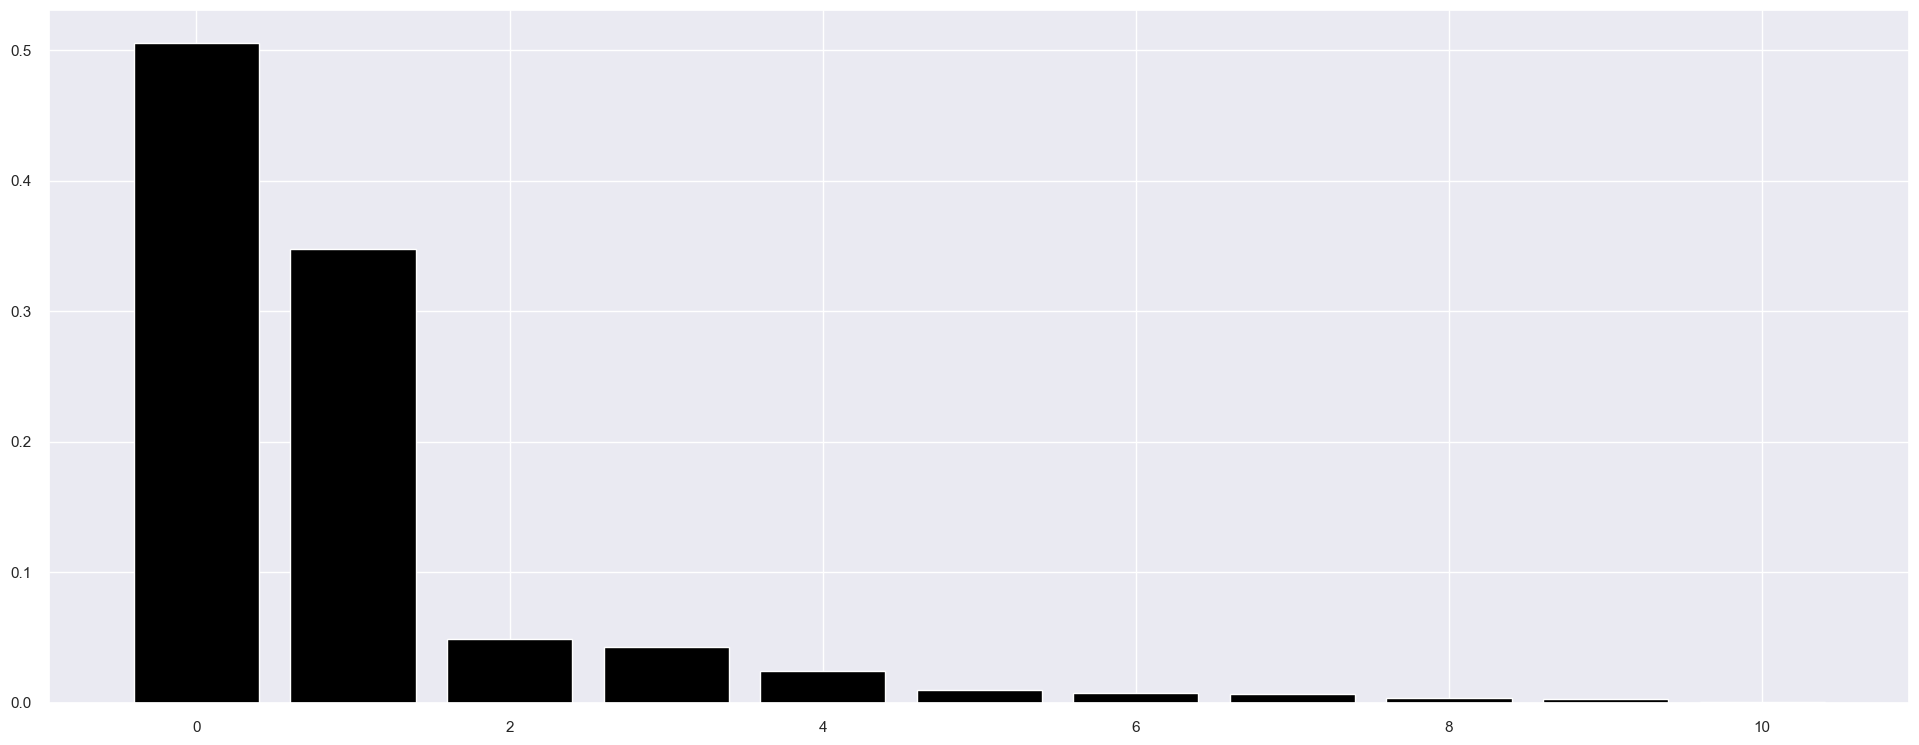

In [266]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X ) 

# Plot Explained Variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# PCA Component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

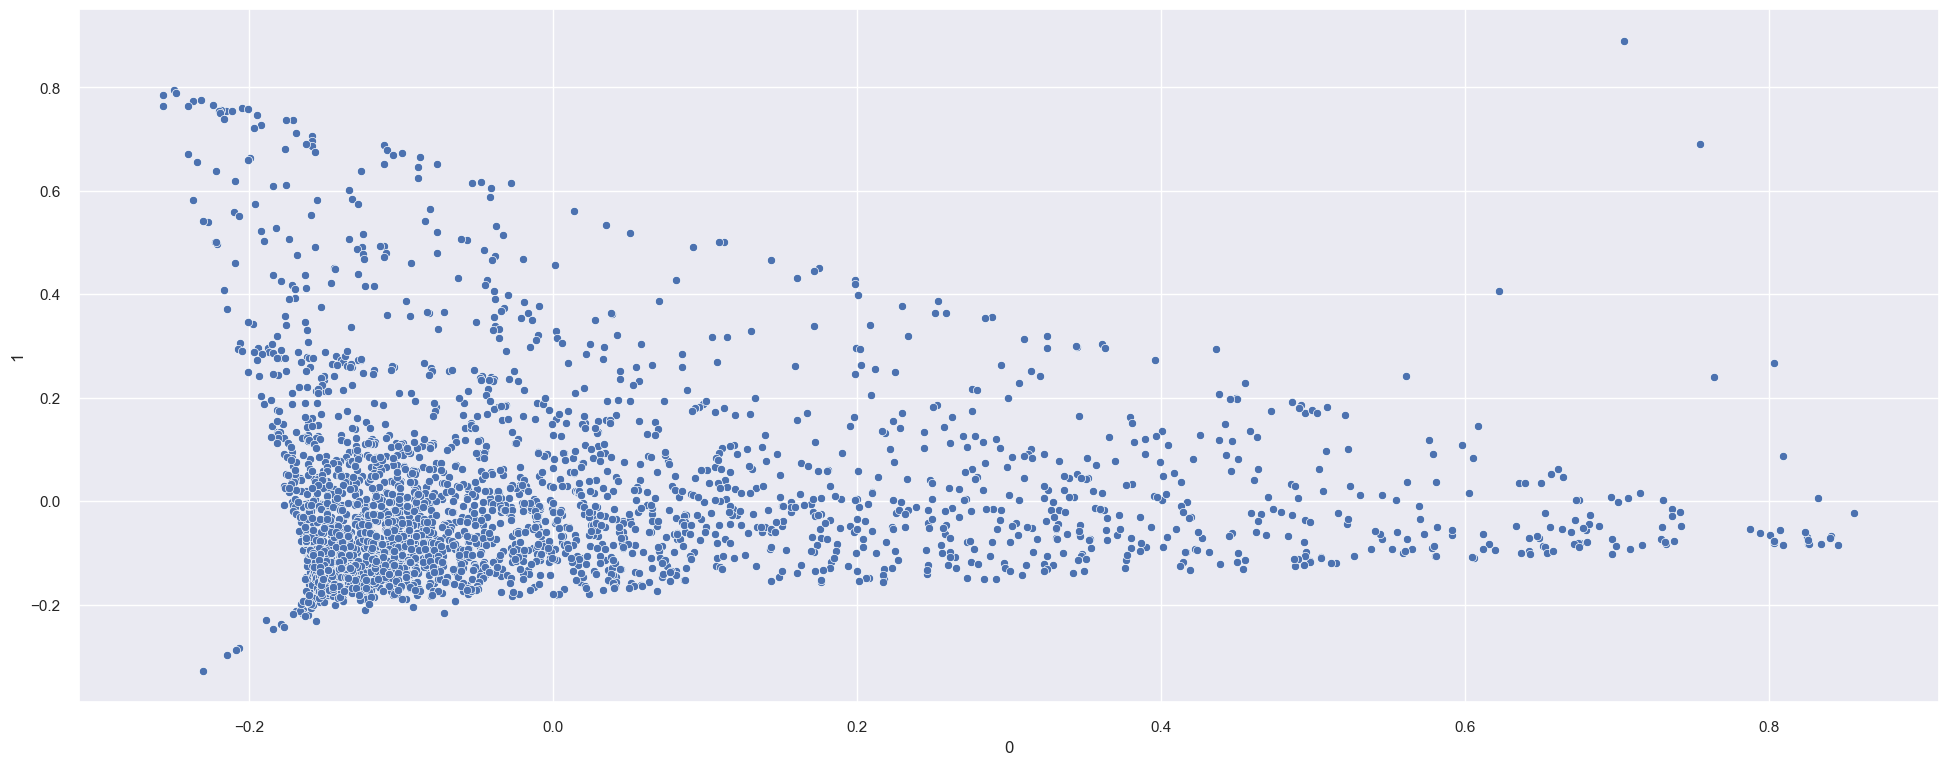

In [267]:
sns.scatterplot( x=0, y=1, data=df_pca )

### UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

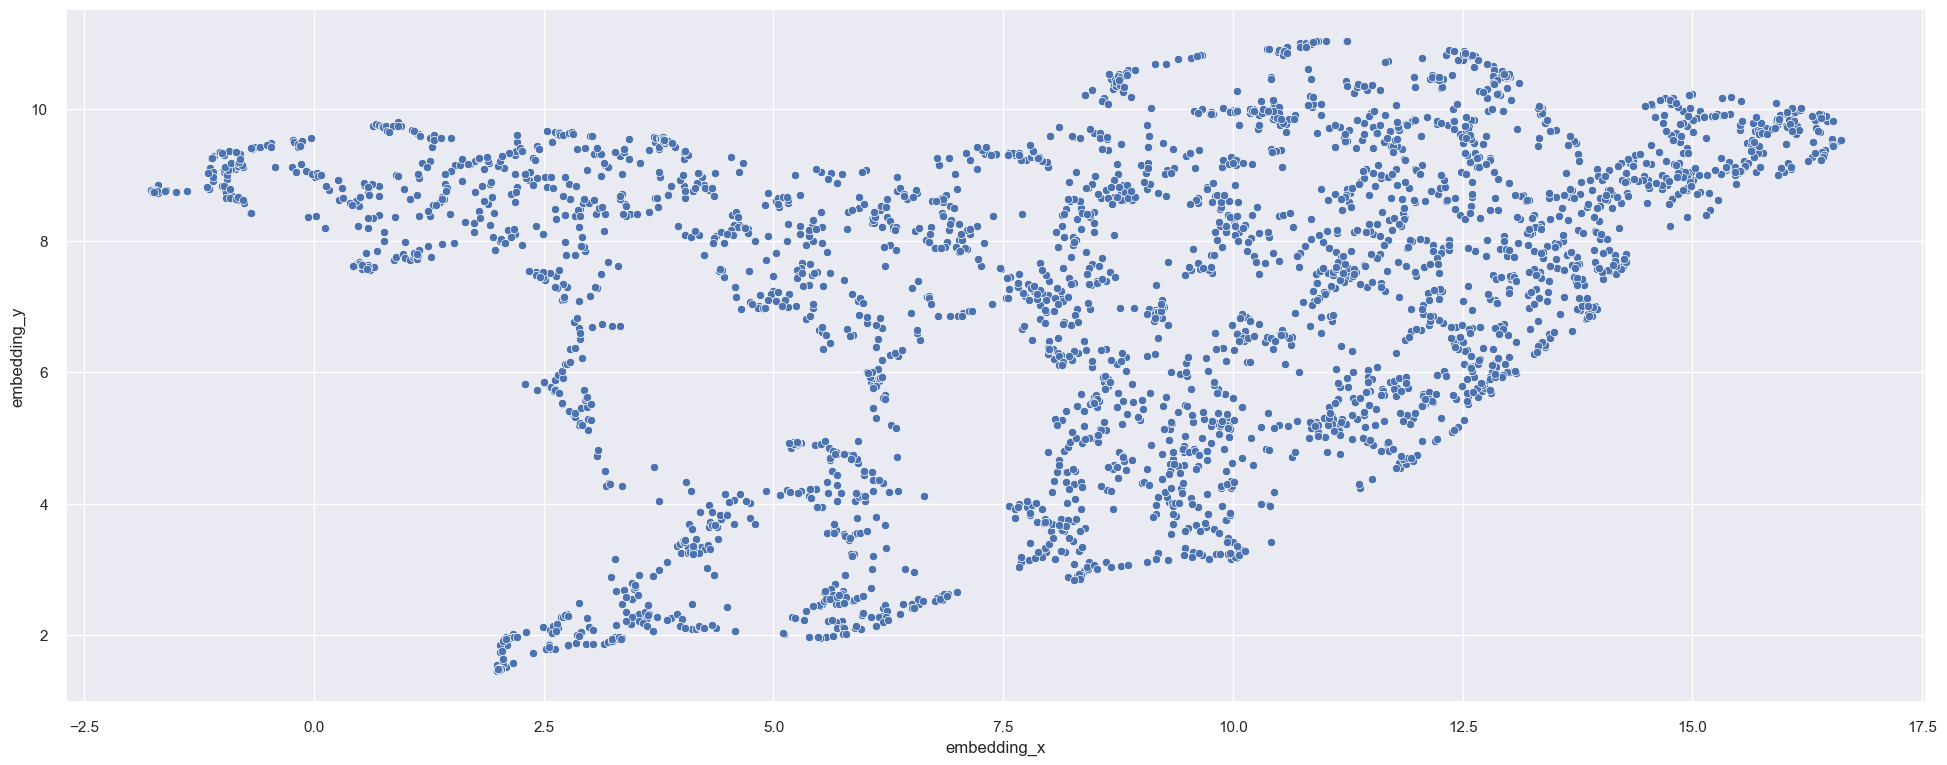

In [268]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# Embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_pca )

### t-SNE

C:\Users\Pedro\repos\pa005_insiders_clustering\pa_insiders_env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Pedro\repos\pa005_insiders_clustering\pa_insiders_env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

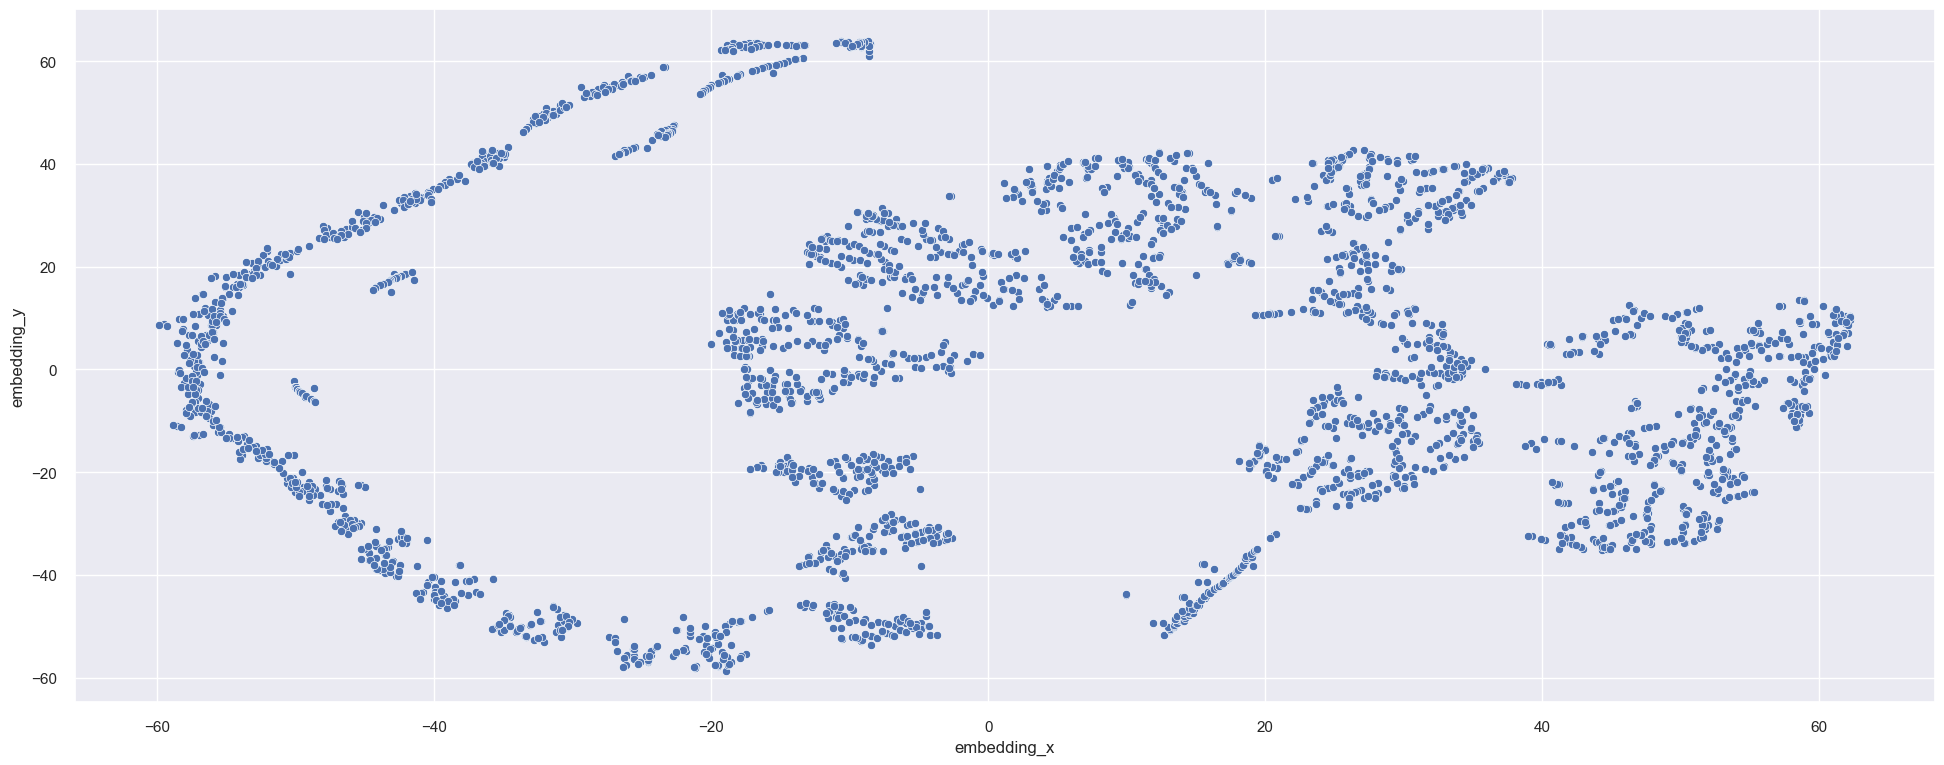

In [259]:
reducer = TSNE( n_components=2, random_state=42, n_jobs=-1 )
embedding = reducer.fit_transform( X )

# Embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_pca )

### Tree-Based Embedding

In [278]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qnt_products', 'frequency', 'qnt_returns']

In [279]:
df4_aux = df4.copy()

In [282]:
df4_aux = df4_aux.drop(columns=['qnt_invoices', 'qnt_items', 'avg_ticket', 'avg_recency_days', 'avg_basket_size', 'avg_unique_basket_size'])

In [284]:
# Training Dataset
X = df4_aux.drop(columns=['gross_revenue', 'customer_id'], axis=1)
y =df4_aux['gross_revenue']

# Model Definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# Model Training
rf_model.fit( X, y )

RandomForestRegressor(random_state=42)

In [285]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

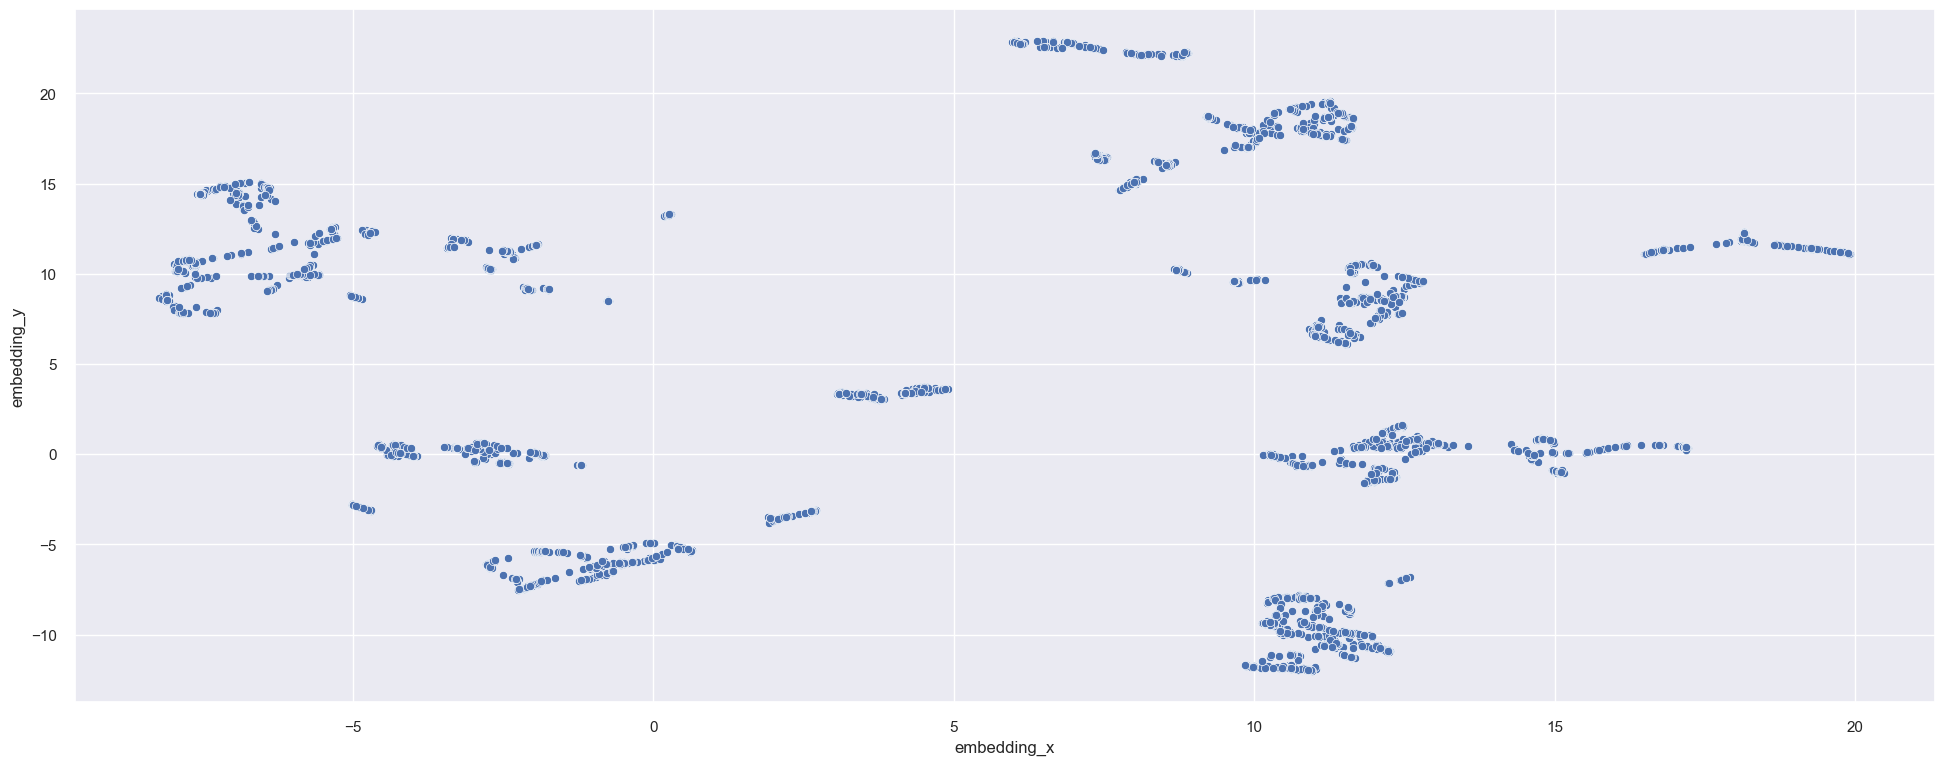

In [286]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tree )

# 5.0. Data Preparation

1. Distribuição normal e não possui outliers -> Standard Scaler
2. Distribuição normal e possui outliers -> Robust Scaler
3. Não distribuição normal -> Min Max Scaler

Testes:
- QQ Plot -> Quantile Quantile Plot (Quantile teorica x Quantile Real)
- KS Teste -> Kolgomorv Smirnoff (Teste de Hipoteses) Se p-value > 0.5 -> Distribuição Normal, p-value < 0.5 -> Não distribuição normal

Detecção de outiliers:
- Box Plot
- IRQ * 2.5 -> Acima desse valor é Outlier

- Z-Score > 3 -> Outlier
- Z-Score < -3 -> Outlier

In [290]:
df5 = df_tree.copy()

In [115]:
#df5 = df4.copy()
#df5_aux = df4.copy()

In [288]:
# Standand Scaler
mm = pp.MinMaxScaler() 
ss = pp.StandardScaler()
rs = pp.RobustScaler()

In [289]:
df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
#df5['qnt_invoices'] = mm.fit_transform( df5[['qnt_invoices']] )
#df5['qnt_items'] = mm.fit_transform( df5[['qnt_items']] )
df5['qnt_products'] = mm.fit_transform( df5[['qnt_products']] )
#df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
df5['frequency'] = mm.fit_transform( df5[['frequency']] )
df5['qnt_returns'] = mm.fit_transform( df5[['qnt_returns']] )
#df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
#df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

KeyError: "None of [Index(['gross_revenue'], dtype='object')] are in the [columns]"

In [292]:
df5.head()

,embedding_x,embedding_y
0,10.351093,18.910801
1,18.187021,11.845822
2,9.566663,18.270248
3,-3.921674,-0.104677
4,-6.384161,9.858138


### Teste de Reescala

In [ ]:
variable = 'gross_revenue'

Min:6.2 - Max: 279138.02


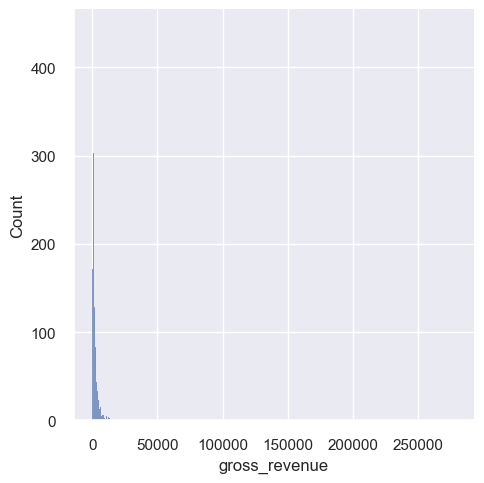

In [107]:
# Dados as IS
print( 'Min:{} - Max: {}'.format( df5_aux[variable].min(), df5_aux[variable].max() ) )
sns.displot(df5_aux[variable]);

Min:0.0 - Max: 1.0


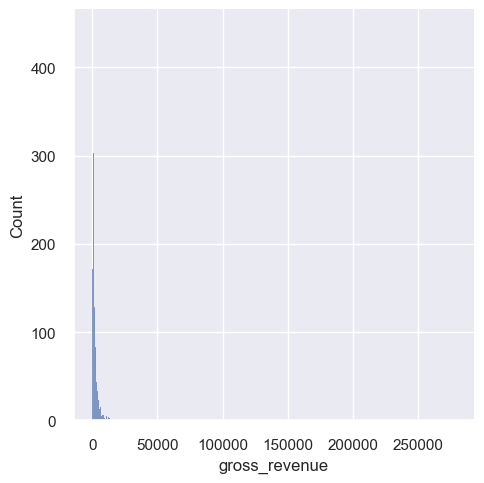

In [108]:
# Dados Normalizados ou Reescalados
print( 'Min:{} - Max: {}'.format( df5[variable].min(), df5[variable].max() ) )
sns.displot(df5_aux[variable]);

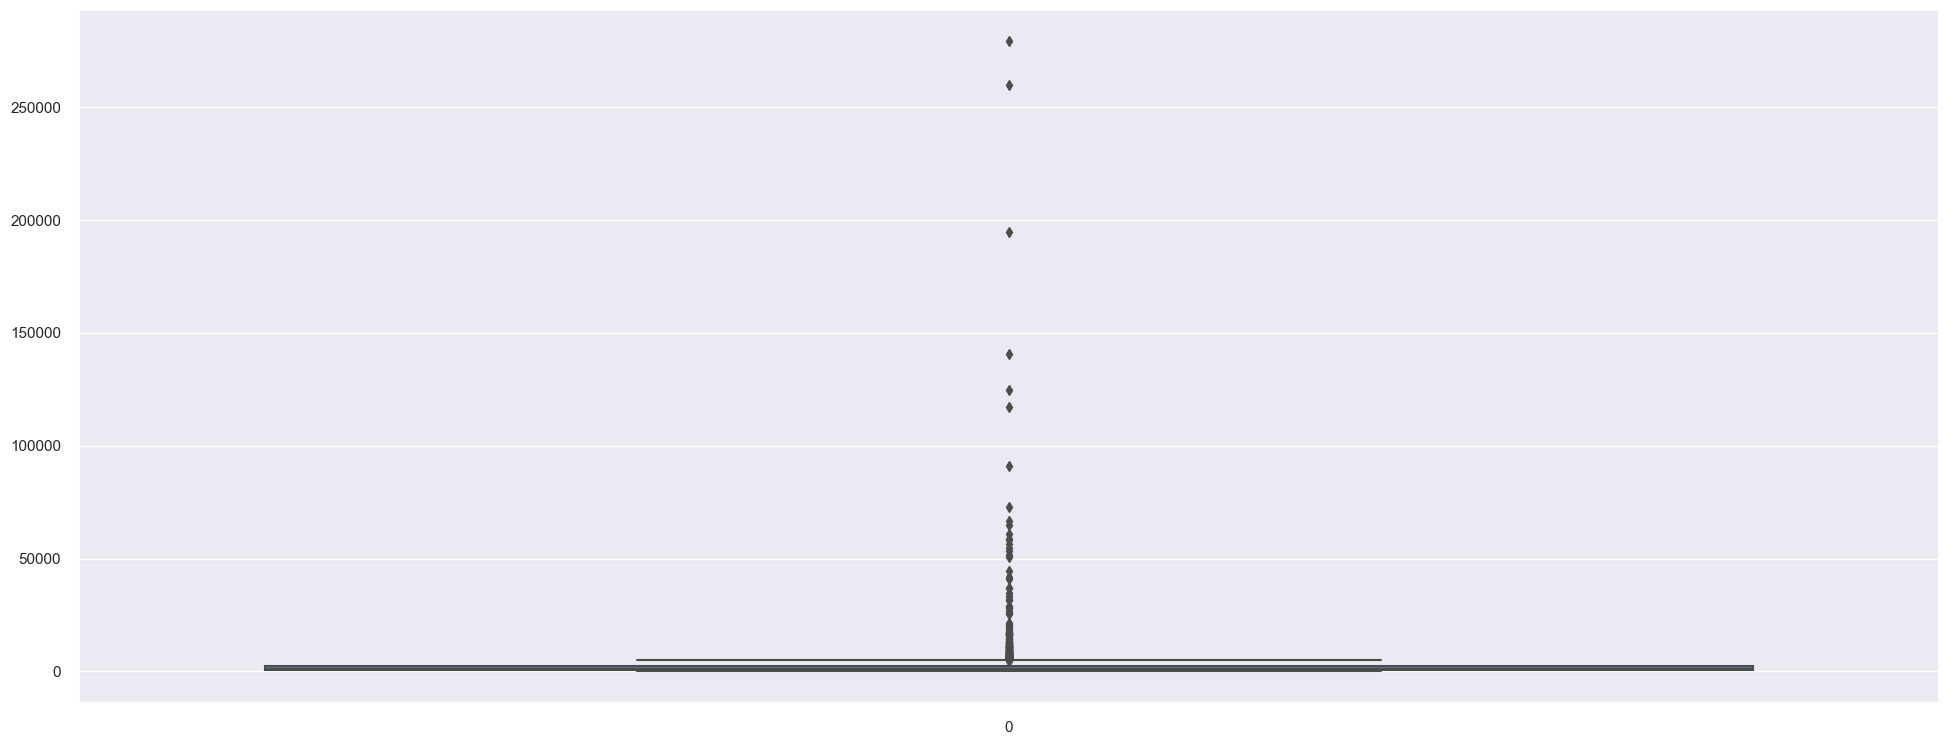

In [103]:
sns.boxplot( df5_aux[variable] );

# 6.0 Feature Selection

In [119]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qnt_products', 'frequency', 'qnt_returns']

In [293]:
#df6 =df5[ cols_selected ].copy()
df6 =df_tree.copy()

# 7.0. Hyper Parameter Fine Tuning

In [294]:
#X = df6.drop(columns=['customer_id'])
X = df_tree.copy()

In [295]:
#clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange(2, 25, 1)

## 7.1. K-Means

In [296]:
kmeans_list = []

for k in clusters:
    # Model Definition
    kmeans_model = c.KMeans( n_clusters=k )

    # Model Training
    kmeans_model.fit( X )

    # Model Prediction
    labels = kmeans_model.predict( X )

    # Model Perfomance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

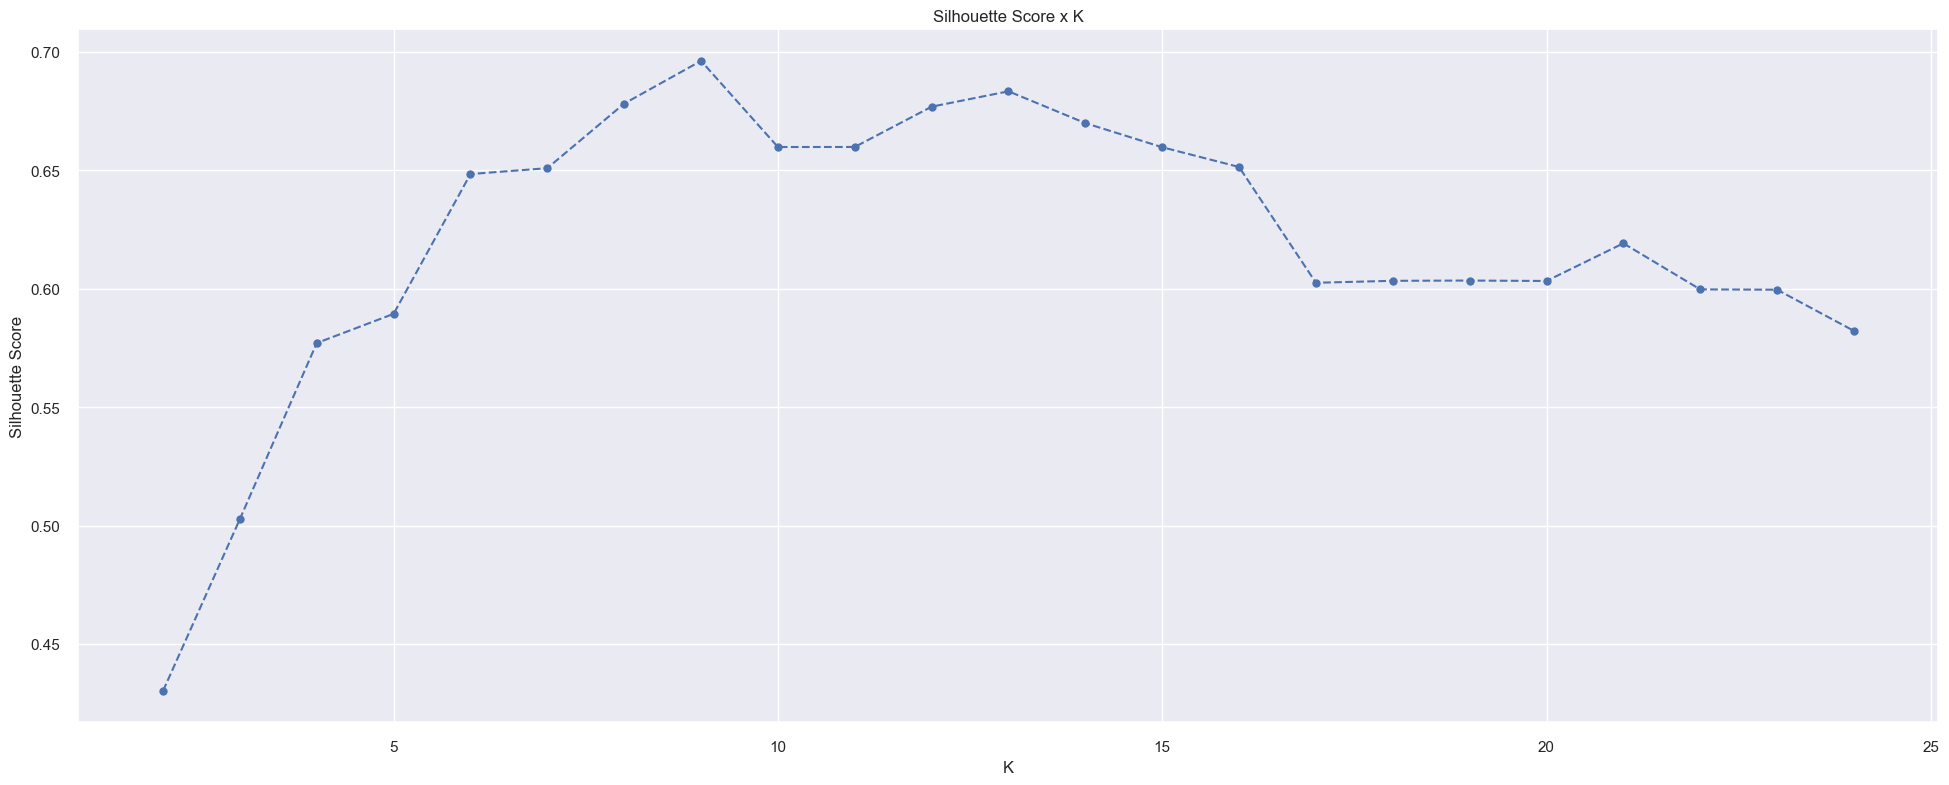

In [297]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.2. GMM

In [298]:
gmm_list = []

for k in clusters:
    # Model Definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # Model Training
    gmm_model.fit( X )

    # Model Prediction
    labels = gmm_model.predict( X )

    # Model Perfomance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

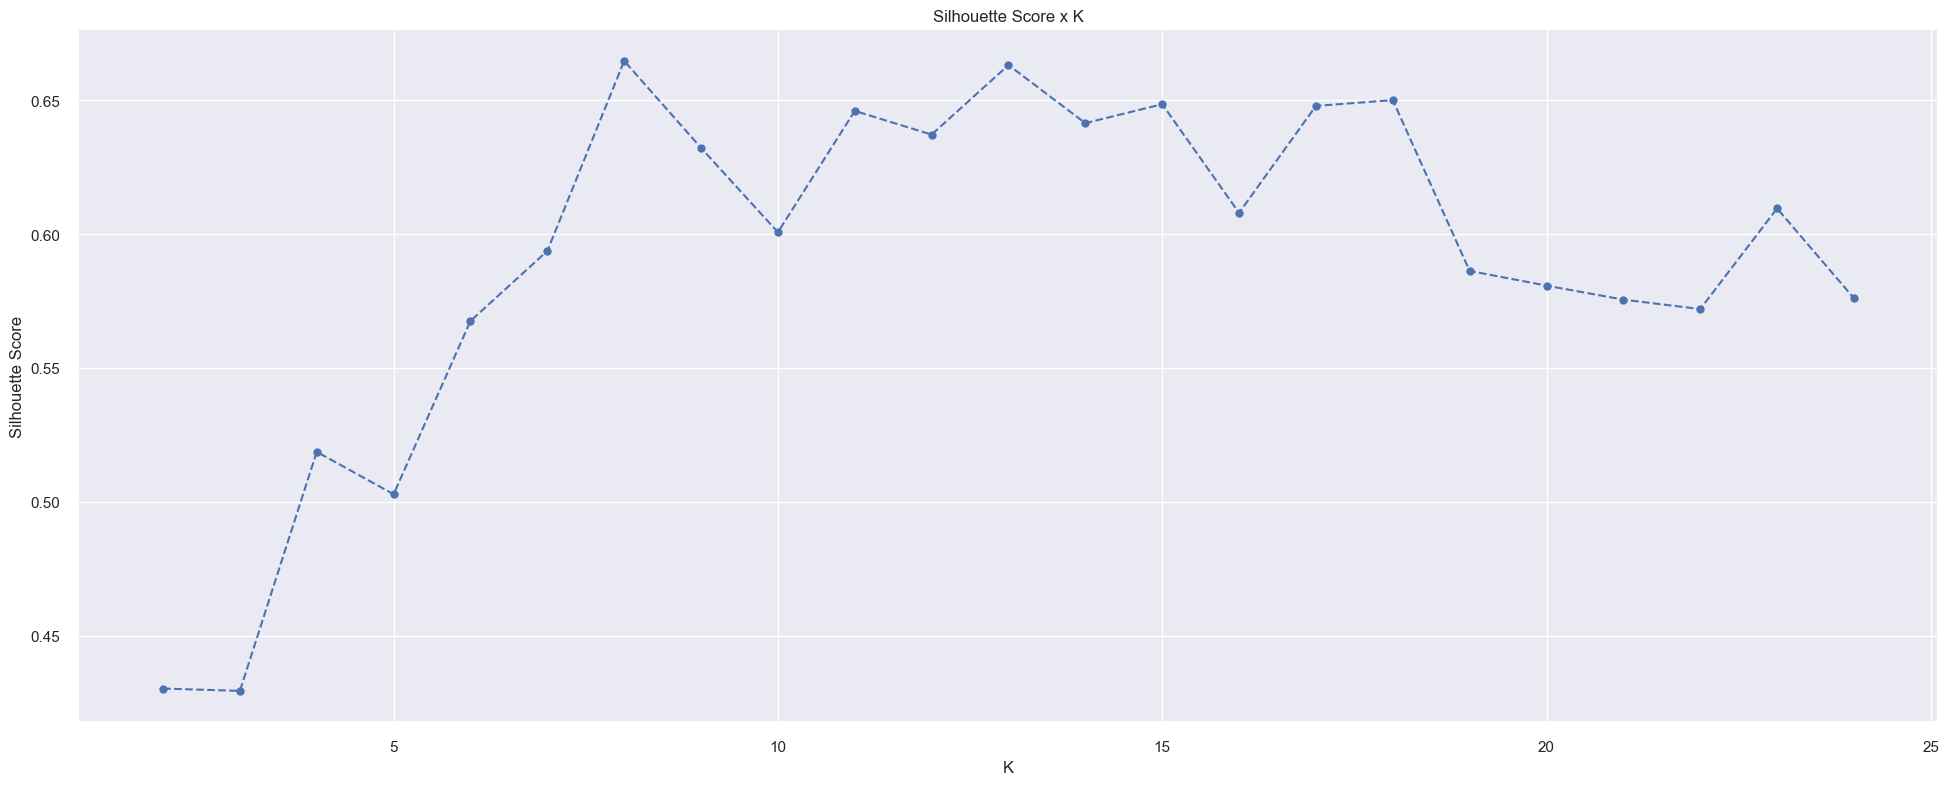

In [299]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.3. Hierarchical Clustering

In [300]:
# Model Definition
hc_model = hc.linkage( X, 'ward' )

[]

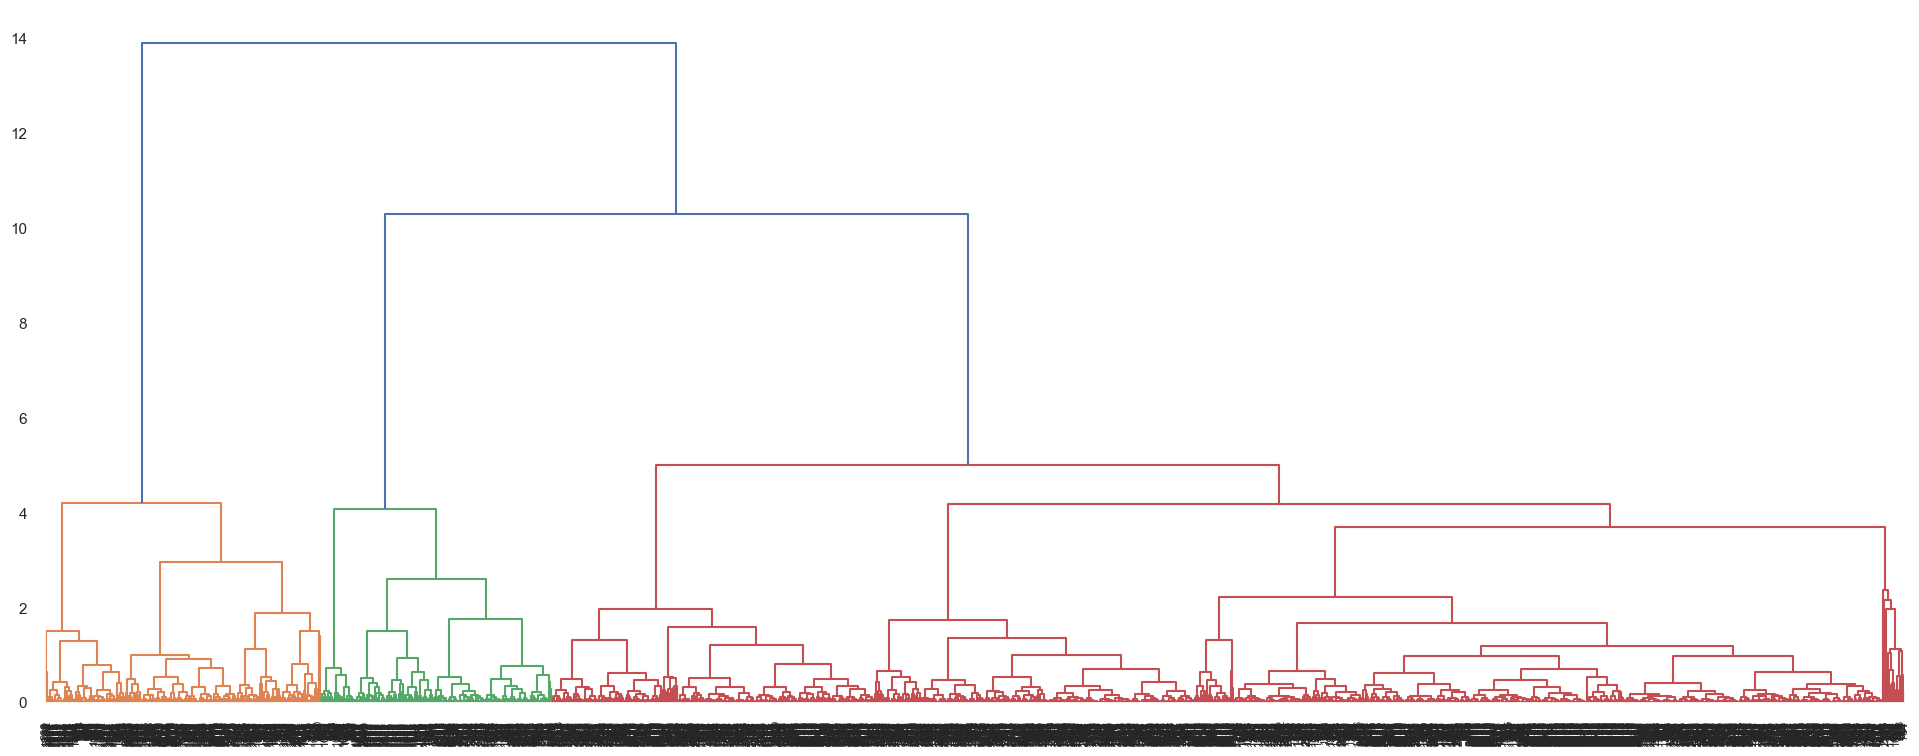

In [78]:
#hc.dendrogram( hc_model, leaf_rotation=90, leaf_font_size=8 )
#plt.plot()

### Sillhouette Score

In [301]:
hc_list = []

for k in clusters:
    
    # Model Definition and Training
    hc_model = hc.linkage( X, 'ward' )

    # Model Predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

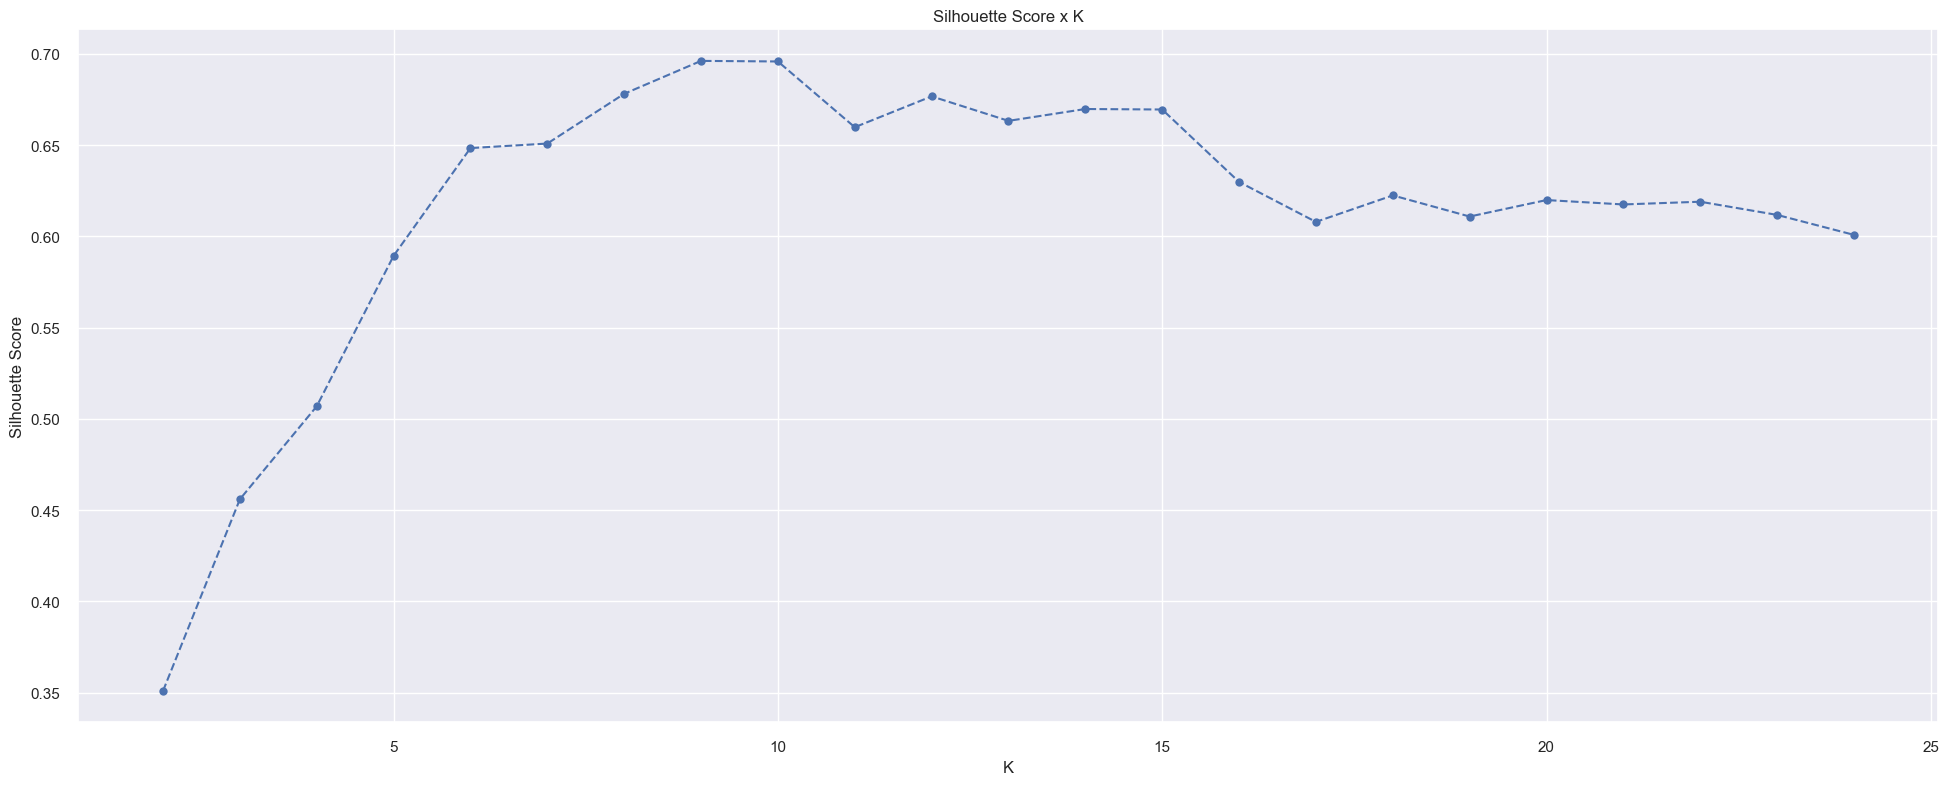

In [302]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 7.4. DBSCAN

In [211]:
eps=0.1
min_samples=40

# Model Definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# Model Training
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len (np.unique( labels ) ) ) )
print( np.unique( labels ) )

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

### Best Radius Value

In [132]:
nighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = nighbors.kneighbors( X )

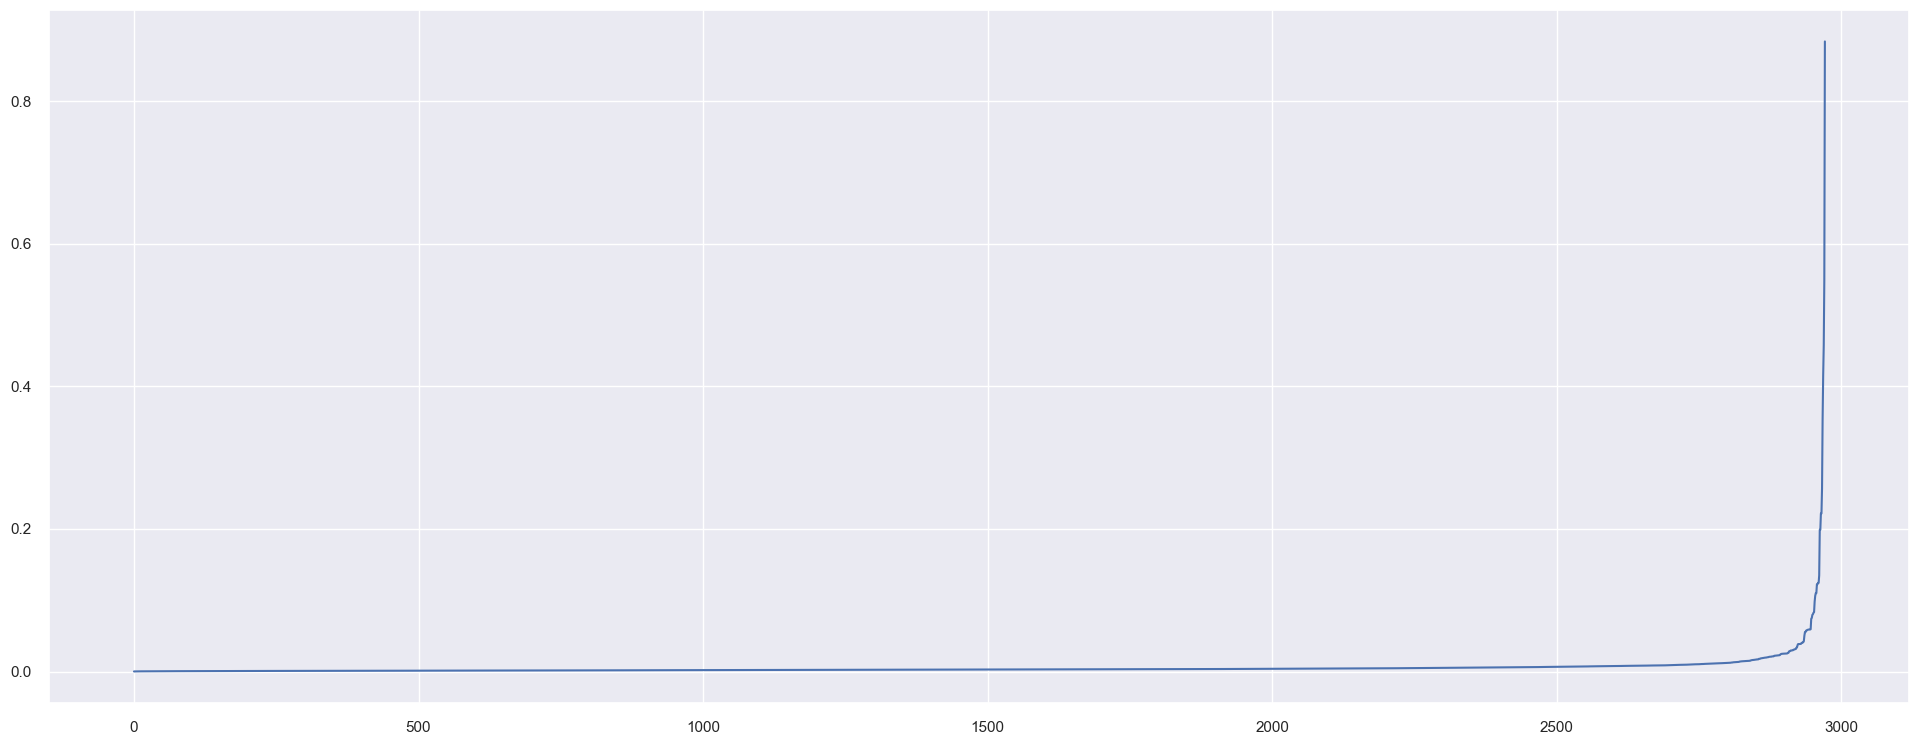

In [133]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

In [136]:
dbscan_list = [0.621510, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [303]:
# Model Name | K=2 | K=3 | K=4
# KMeans     | SS  | SS  | SS
# GMM        | SS  | SS  | SS
# HC         | SS  | SS  | SS
# DBSCAN     | SS  | SS  | SS

df_results = pd.DataFrame( { 'KMeans': kmeans_list, 'GMM': gmm_list, 'HC': hc_list } ).T
df_results.columns = clusters

In [304]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.430203,0.502728,0.577019,0.589342,0.648354,0.650833,0.678091,0.696116,0.659765,0.659785,0.676786,0.683277,0.669851,0.659675,0.651336,0.602462,0.603288,0.603402,0.603219,0.619110,0.599666,0.599537,0.582153
GMM,0.430203,0.429322,0.518665,0.502824,0.567579,0.593757,0.664793,0.632272,0.600748,0.646092,0.637248,0.663240,0.641523,0.648605,0.607999,0.647973,0.650123,0.586290,0.580799,0.575560,0.572031,0.609632,0.576094
HC,0.351003,0.455992,0.506919,0.589342,0.648354,0.650833,0.678091,0.696116,0.695799,0.659785,0.676691,0.663265,0.669756,0.669484,0.629807,0.607922,0.622431,0.610854,0.619880,0.617472,0.618971,0.611748,0.600812


# 8.0 Model Training

## 8.1. K-Means

In [234]:
# Model Definition
k = 7
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# Model Training
kmeans.fit( X )

# Clustering
labels = kmeans.labels_

## GMM

In [313]:
k = 9

# Model Definition
gmm_model = mx.GaussianMixture( n_components=k )

# Model Training
gmm_model.fit( X )

# Model Prediction
labels = gmm_model.predict( X )

# Model Perfomance
#sil = m.silhouette_score( X, labels, metric='euclidean' )
#gmm_list.append( sil )

### 8.1.1. Cluster Validation

In [235]:
# WSS (Within-cluster sum of square)
print('WSS Value: {}'.format(kmeans.inertia_) )

# SS (Silhouette Score)
print('SS Value: {}'.format(m.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS Value: 32639.21484375
SS Value: 0.6025143265724182


# 9.0 Cluster Analyses

In [314]:
df9 = X.copy()
df9['clusters'] = labels

In [315]:
#df9 = df4.copy()
#df9['clusters'] = labels
df9.head()

,embedding_x,embedding_y,clusters
0,10.351093,18.910801,6
1,18.187021,11.845822,0
2,9.566663,18.270248,6
3,-3.921674,-0.104677,7
4,-6.384161,9.858138,1


## 9.1. Visualization Inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

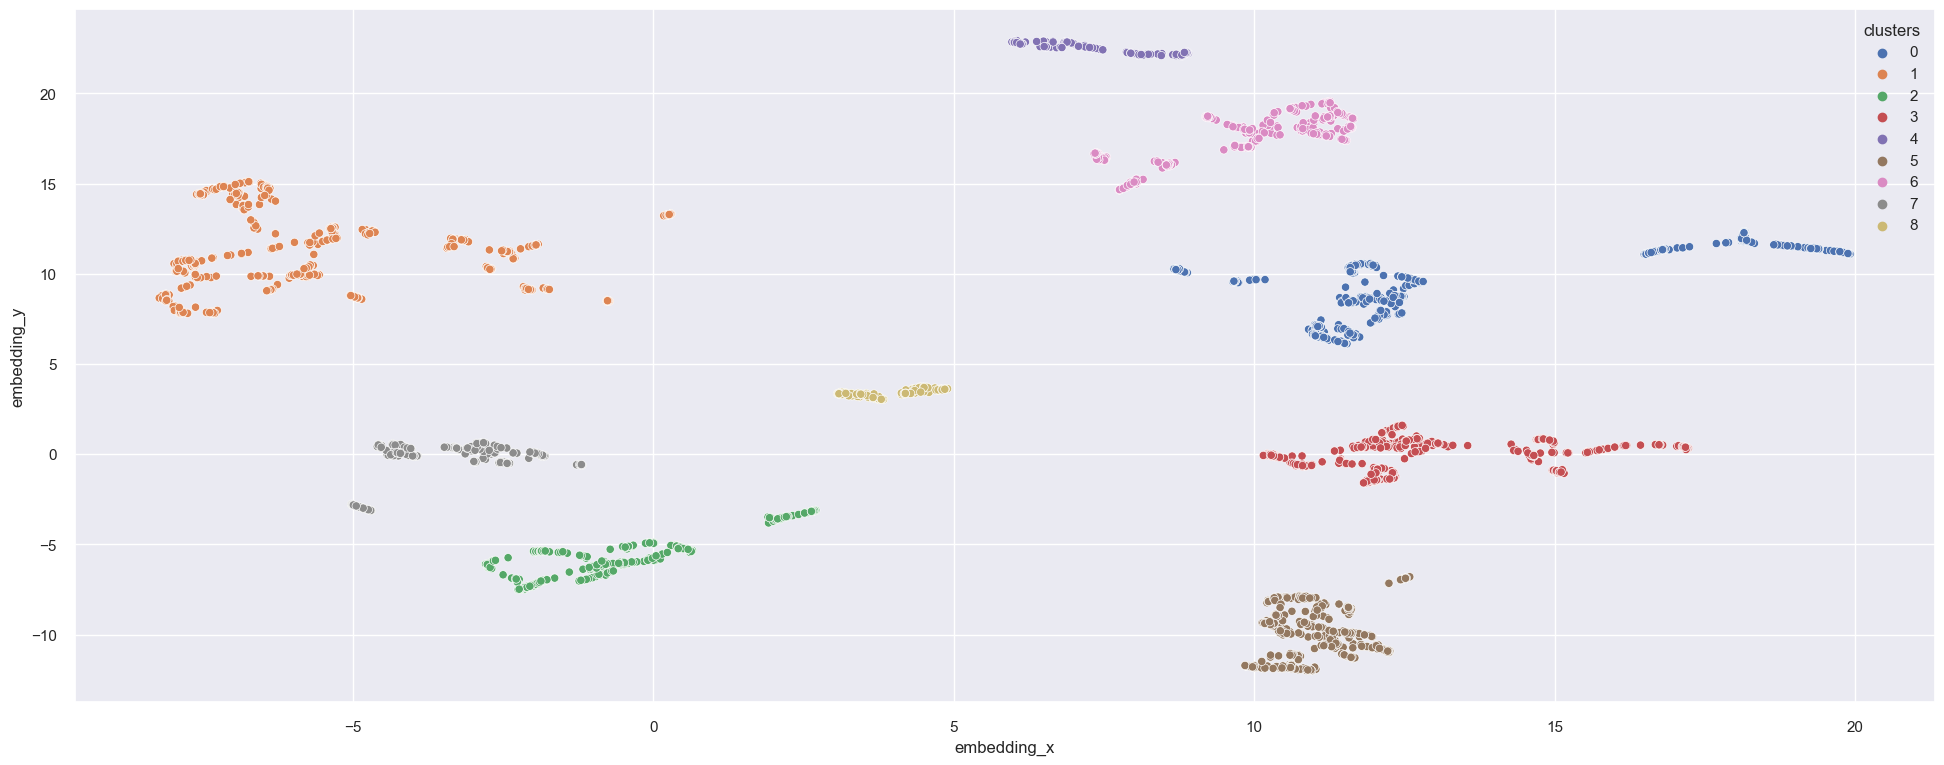

In [316]:
#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
#visualizer.fit(X)
#visualizer.finalize()
sns.scatterplot( x='embedding_x', y='embedding_y', hue='clusters', data=df9, palette='deep'  )

## 9.2. 2D Plot

In [239]:
df_viz = df9.drop(columns=['customer_id'], axis=1)
#sns.pairplot( df_viz, hue='clusters' )

KeyError: "['customer_id'] not found in axis"

## 9.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

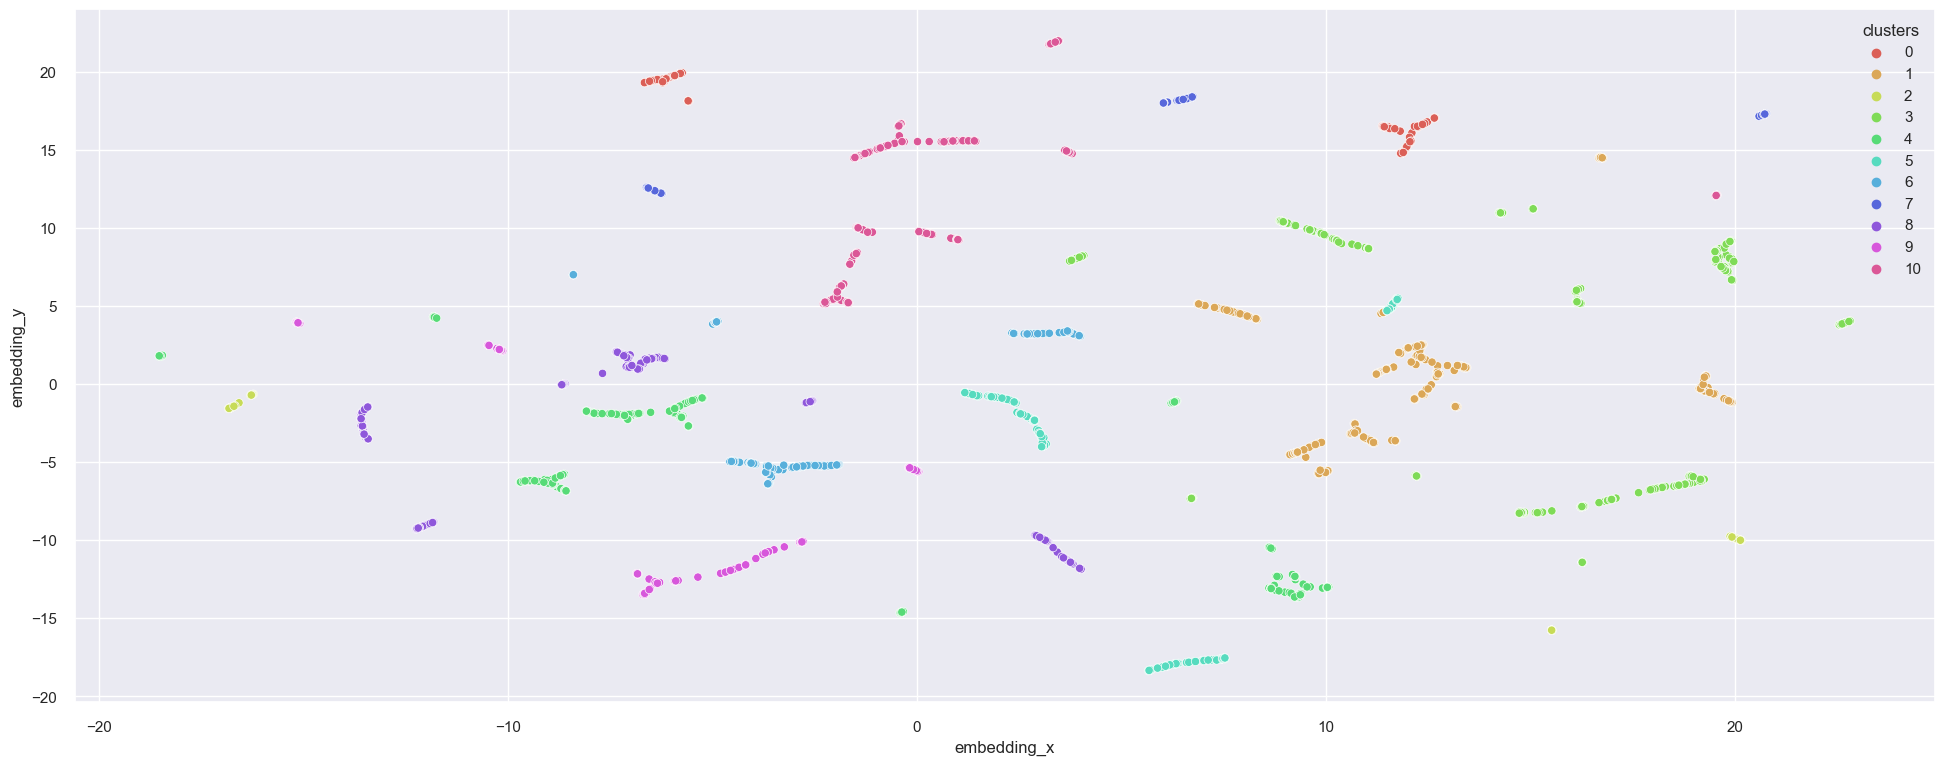

In [219]:
reducer = umap.UMAP( random_state=90, n_neighbors=20 )
embedding = reducer.fit_transform( X )

# Embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', hue='clusters', palette=sns.color_palette( 'hls', n_colors=len( df_viz['clusters'].unique() ) ), data=df_viz )

## 9.4. Cluster Profile

In [152]:
# Numbers of Customers
df_cluster = df9[['clusters', 'customer_id']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue
df_avg_gross_revenue = df9[['clusters', 'gross_revenue']].groupby( 'clusters' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, on='clusters', how='inner' )

# Avg Recency Days
df_avg_recency_days = df9[['clusters', 'recency_days']].groupby( 'clusters' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, on='clusters', how='inner' )

# Avg Invoice_no
df_avg_invoice_no = df9[['clusters', 'qnt_products']].groupby( 'clusters' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, on='clusters', how='inner' )

# Frequecy
df_frequency = df9[['clusters', 'frequency']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, on='clusters', how='inner' )

# qnt_returns
df_returns = df9[['clusters', 'qnt_returns']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns, on='clusters', how='inner' )

In [153]:
df_cluster

,clusters,customer_id,perc_customer,gross_revenue,recency_days,qnt_products,frequency,qnt_returns
0,0,658,22.139973,1201.958526,102.460486,61.800912,0.121554,9.658055
1,1,1983,66.722746,3490.634095,20.660615,157.032779,0.068096,41.073122
2,2,331,11.137281,860.203716,246.184290,37.676737,0.408725,47.577039


# 10.0 Deploy to Production